In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import diags
%matplotlib inline

# The Diffusion equation

The partial differential equation under consideration is 
$$\frac{\partial u}{\partial t}=c^2\frac{\partial^2 u}{\partial x^2}$$
In this assignment, this equation will be solved numerically using the finite difference method involving the Implicit (FTCS), Explicit (BTCS) and the Crank-Nicolson schemes.\\
The initial conditions are written as,
$$u(x,0)=f(x)$$
and boundary conditions,
$$u(0,t)=T_i$$
$$u(L,t)=T_f$$
Firstly, codes will be written for any general initial and boundary conditions.

# The Implicit Scheme

The set of linear equations found in the implicit scheme for the diffusion equation are
$$u(j,n) = -\lambda [ u(j+1,n+1) + u(j-1,n+1)]+(1+2\lambda)u(j,n+1)$$

In [85]:
def implicitDiff(Ti,Tf,f,L,T,l,M,N):
    # '\lambda' = l
    # L = length of the system, M = total steps
    # T = Total time. N = Total time steps
    
    # inittial condition: f(x)
    # boundary condition: Ti, Tf
    
    # space grid
    x_grid = np.linspace(-L,L,M)
    
    # time grid
    t_grid = np.linspace(0,T,N)
    
    del_x = L/(M-1)
    del_t = T/(N-1)
    
    # the u field
    u = np.zeros((M,N))
    
    # initial condition. Given any function u(x) at t=0
    u[:,0] = f(x_grid)
    
    # boundary condition
    u[0,:] = Ti
    u[-1,:] = Tf
    
    # defining the tri-diagonal matrix using sparse matrix representation
    main = np.zeros(M-2)
    upper = np.zeros(M-3)
    lower = np.zeros(M-3)
    
    main[:] = 1 + 2*l
    upper[:] = -l
    lower[:] = -l
    
    A = diags(
    diagonals=[main, lower, upper],
    offsets=[0, -1, 1], shape=(M-2,M-2),
    format='csr')
    print(A.todense())
    A = A.toarray()
    
    for i in range(1, N):
        
        b = np.array(u[1:M-1, i-1])
        
        #print(b)
        u[1:M-1, i] = np.linalg.solve(A,b)  
   
    return (u, t_grid, x_grid)

# The Explicit scheme 

The formula of the diffusion equation in the explicit scheme is 
$$u(j,n+1) = \lambda [u(j+1,n) + u(j-1,n)] + (1-2*\lambda)u(j,n)$$
In the following code, this equation will be solved for a general case.

In [95]:
def explicitDiff(Ti,Tf,f,L,T,l,M,N):
    # Notations are same as that of the implicit scheme.
    # space grid
    x_grid = np.linspace(0,L,M)
    
    # time grid
    t_grid = np.linspace(0,T,N)
    
    del_x = L/(M-1)
    del_t = T/(N-1)
    
    # the u field
    u = np.zeros((M,N))
    
    # initial condition. Given any function u(x) at t=0
    u[:,0] = f(x_grid)
    
    # boundary condition
    u[0,:] = Ti
    u[-1,:] = Tf
    
    for i in range(N-1):
        for j in range(1,M-1):
            u[j,i+1] = l*u[j-1,i] + l*u[j+1,i] + (1-2*l)*u[j,i]
    
    return (u,t_grid,x_grid)

# The Crank-Nicolson scheme
The equation in this case is 
$$-\lambda u(j-1,n+1) + 2(1+\lambda)u(j,n-1) - \lambda u(j+1,n+1) = \lambda u(j-1,n) + 2(1-\lambda)u(j,n) + \lambda u(j+1,n)$$
The domain considered is $[0,L]\times[0,T]$. This can easily be generalised.

In [130]:
def CrankNicolson(Ti,Tf,f,L,T,l,M,N):
    # Notations are same as that of the implicit scheme.
    
    # space grid
    x_grid = np.linspace(0,L,M)
    
    # time grid
    t_grid = np.linspace(0,T,N)
    
    del_x = L/(M-1)
    del_t = T/(N-1)
    
    # the u field
    u = np.zeros((M,N))
    
    # initial condition. Given any function u(x) at t=0
    u[:,0] = f(x_grid)
    
    # boundary condition
    u[0,:] = Ti
    u[-1,:] = Tf
    
    # Two matrices need to be defined in this case.
    # First
    main1 = np.zeros(M-2)
    upper1 = np.zeros(M-3)
    lower1 = np.zeros(M-3)
    
    main1[:] = 2 + 2*l
    upper1[:] = -l
    lower1[:] = -l
    
    A1 = diags(
    diagonals=[main1, lower1, upper1],
    offsets=[0, -1, 1], shape=(M-2,M-2),
    format='csr')
    print(A1.todense())
    A1 = A1.toarray()
    Ainv = np.linalg.inv(A1)
    
    # Second
    main2 = np.zeros(M-2)
    upper2 = np.zeros(M-3)
    lower2 = np.zeros(M-3)
    
    main2[:] = 2 - 2*l
    upper2[:] = l
    lower2[:] = l
    
    A2 = diags(
    diagonals=[main2, lower2, upper2],
    offsets=[0, -1, 1], shape=(M-2,M-2),
    format='csr')
    print(A2.todense())
    A2 = A2.toarray()
    
    for k in range(1, N):
        ci = np.zeros((M-4,1)).ravel()
        b1 = np.asarray([l*u[0,k]+l*u[0,k-1],l*u[-1,k]+l*u[-1,k-1]])
        b1 = np.insert(b1, 1, ci)
        b2 = np.dot(A2, np.array(u[1:M-1, k-1]))
        b = b1 + b2  
        # Solving the matrix equation
        u[1:M-1, k] = np.linalg.solve(A1,b)  
    return (u, t_grid, x_grid)

# The implicit scheme with given conditions
The problem of diffusion is solved using the implicit scheme using the following conditions.
Initial condition,
$$u(x,0) = e^{-x^2}$$
Boundary condition,
$$u(-L,t) = u(L,t) = 0$$
Space interval L = 5

Space discretization step △x = 0.1

Time discretization step △t = 0.05

Amount of time steps T = 200

Domain = $[-L,L]\times[0,T]$

In [82]:
def g(x):
    return np.e**(-x**2)

[[ 1.1  -0.05  0.   ...  0.    0.    0.  ]
 [-0.05  1.1  -0.05 ...  0.    0.    0.  ]
 [ 0.   -0.05  1.1  ...  0.    0.    0.  ]
 ...
 [ 0.    0.    0.   ...  1.1  -0.05  0.  ]
 [ 0.    0.    0.   ... -0.05  1.1  -0.05]
 [ 0.    0.    0.   ...  0.   -0.05  1.1 ]]
Above is the matrix A removing the first and last rows and columns (boundary condition)


Text(0.5, 1.0, 'Implicit scheme')

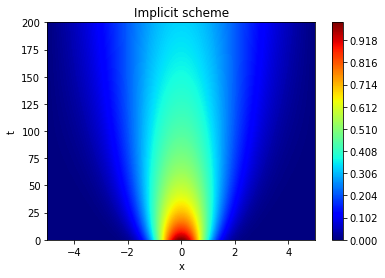

In [156]:
u,t,x = implicitDiff(0,0,g,5,200,0.05,101,4001)
u=np.transpose(u)
print('Above is the matrix A removing the first and last rows and columns (boundary condition)')
plt.contourf(x,t,u,500, cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Implicit scheme')

# Explicit scheme with given conditions

The problem of diffusion is solved using the explicit scheme using the following conditions.
Initial condition,
$$u(x,0) = 4x(1-x)$$
Boundary condition,
$$u(0,t) = u(L,t) = 0$$

Space interval, L = 1.

Amount of space points, M = 10.

Amount of time steps, T = 30.

Domain = $[0,L]\times[0,T]$

In [103]:
def f(x):
    return 4*x*(1-x)

Text(0.5, 1.0, 'Explicit scheme')

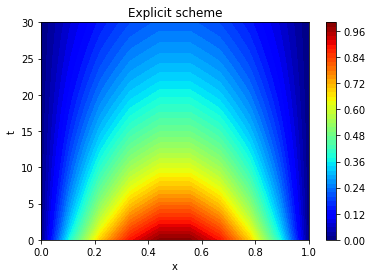

In [104]:
u,t,x = explicitDiff(0,0,f,1,30,1/8,10,100)
u=np.transpose(u)
plt.contourf(x,t,u,50, cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Explicit scheme')

# Crank-Nicolson scheme with given conditions

The problem of diffusion is solved using the explicit scheme using the following conditions.
Initial condition,
$$u(x,0) = 2-1.5x+\sin(\pi x)$$
Boundary condition,
$$u(0,t) = 2, u(L,t) = 0.5$$

Space interval L=1

Space discretization step △x = 0.1

Time discretization step △t = 0.05

Amount of time steps T = 15

In [106]:
def h(x):
    return 2-1.5*x+np.sin(np.pi*x)

[[ 2.4 -0.2  0.   0.   0.   0.   0.   0.   0. ]
 [-0.2  2.4 -0.2  0.   0.   0.   0.   0.   0. ]
 [ 0.  -0.2  2.4 -0.2  0.   0.   0.   0.   0. ]
 [ 0.   0.  -0.2  2.4 -0.2  0.   0.   0.   0. ]
 [ 0.   0.   0.  -0.2  2.4 -0.2  0.   0.   0. ]
 [ 0.   0.   0.   0.  -0.2  2.4 -0.2  0.   0. ]
 [ 0.   0.   0.   0.   0.  -0.2  2.4 -0.2  0. ]
 [ 0.   0.   0.   0.   0.   0.  -0.2  2.4 -0.2]
 [ 0.   0.   0.   0.   0.   0.   0.  -0.2  2.4]]
[[1.6 0.2 0.  0.  0.  0.  0.  0.  0. ]
 [0.2 1.6 0.2 0.  0.  0.  0.  0.  0. ]
 [0.  0.2 1.6 0.2 0.  0.  0.  0.  0. ]
 [0.  0.  0.2 1.6 0.2 0.  0.  0.  0. ]
 [0.  0.  0.  0.2 1.6 0.2 0.  0.  0. ]
 [0.  0.  0.  0.  0.2 1.6 0.2 0.  0. ]
 [0.  0.  0.  0.  0.  0.2 1.6 0.2 0. ]
 [0.  0.  0.  0.  0.  0.  0.2 1.6 0.2]
 [0.  0.  0.  0.  0.  0.  0.  0.2 1.6]]


Text(0.5, 1.0, 'Crank Nicolson scheme')

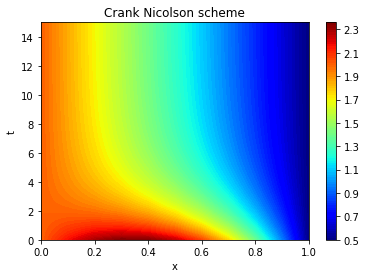

In [135]:
u,t,x = CrankNicolson(2,0.5,h,1,15,0.2,11,301)
u=np.transpose(u)
plt.contourf(x,t,u,100, cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Crank Nicolson scheme')

# 2 dimensional diffusion
$$\frac{\partial u}{\partial t}=c^2[\frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial y^2}]$$
Using FTCS method, this can be solved by using the equation,
$$u_{ij}^{n+1} = \alpha (u_{i-1j}^n + u_{i+1j}^n) + \beta (u_{ij-1}^n + u_{ij+1}^n) + (1-2\alpha - 2\beta)u_{ij}^n$$


In [136]:
def f2(x,y,L):
    return np.e**(-20*(x-L/2)**2-20*(y-L/2)**2)

In [160]:
def diff2d(M,L,f,a,b,dt,T):
    u_time = []
    
    # define u(x,y) at a particular time
    u_xy = np.zeros((M,M))
    
    # forming grid
    x_grid = np.linspace(0,L,M)
    y_grid = np.linspace(0,L,M)
    
    # total time steps
    N = T/dt
    
    # Boundary conditions
    u_xy[:,0] = 0
    u_xy[:,M-1] = 0
    u_xy[0,:] = 0
    u_xy[M-1,:] = 0
    
    for i in range(int(N)):
        if (i==0):
            for k in range(1,M-1):
                u_xy[1:M-1,k] = f(np.delete(x_grid,(0,M-1)),k,L)
            plt.contourf(x_grid,y_grid,u_xy,100, cmap='jet')
            plt.colorbar()
            plt.xlabel('x')
            plt.ylabel('t')
        for l in range(1,M-1):
            for m in range(1,M-1):
                u_xy[l,m] = a*(u_xy[l-1,m]+u_xy[l+1,m]) + b*(u_xy[l,m-1]+u_xy[l,m+1]) + (1-2*a-2*b)*u_xy[l,m]
        u_time.append(u_xy)
        
        if (i == 50):
            plt.contourf(x_grid,y_grid,u_xy,100, cmap='jet')
            plt.colorbar()
            plt.xlabel('x')
            plt.ylabel('t')
        if (i == 100):
            plt.contourf(x_grid,y_grid,u_xy,100, cmap='jet')
            plt.colorbar()
            plt.xlabel('x')
            plt.ylabel('t')
        if (i == 150):
            plt.contourf(x_grid,y_grid,u_xy,100, cmap='jet')
            plt.colorbar()
            plt.xlabel('x')
            plt.ylabel('t')

KeyboardInterrupt: 

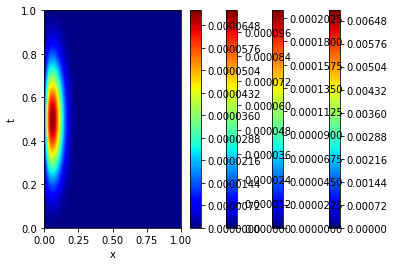

In [161]:
u = diff2d(100,1,f2,0.1,0.1,0.01,40)